In [40]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import ttest_ind
import sys
import os
import re

In [41]:
#Note: For the entirety of this notebook, the words "collab" and "collaboration" 
    #refer to songs with three or more credited artists. "Non-solo" songs are any
    #songs with more than one contributor- both duets and collabs are "non-solo" 
    #songs. -Kelly

In [42]:
#read in data.csv
csv_path = "Resources/data.csv"
data_df = pd.read_csv(csv_path)

data_df

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
170649,0.7340,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
170650,0.6370,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.1950,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055


In [43]:
#create new row with the number of artists performing on each track

#create a new dataframe with only the "artists" column from data.csv to make it easier to work with
artist_df = pd.DataFrame(data_df['artists'])
artist_df["collaborators"] = ""

#count number of artists per track by counting the number of commas in the "artists" column for each row, then adding 1.
for index, row in artist_df.iterrows():
    row["collaborators"] = row["artists"].count(",") + 1

#join the two dataframes together and drop the duplicate "artists" column
practice2_df = data_df.join(artist_df, lsuffix="DROP").filter(regex="^(?!.*DROP)")
practice2_df



,valence,year,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists,collaborators
0,0.0594,1921,0.98200,0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",3
1,0.9630,1921,0.73200,0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,['Dennis Day'],1
2,0.0394,1921,0.96100,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,1
3,0.1650,1921,0.96700,0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109,['Frank Parker'],1
4,0.2530,1921,0.95700,0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,['Phil Regan'],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",5
170649,0.7340,2020,0.20600,0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936,['Ashnikko'],1
170650,0.6370,2020,0.10100,0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688,['MAMAMOO'],1
170651,0.1950,2020,0.00998,0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055,['Eminem'],1


In [44]:
#Gather some general data about the dataset and create some variables for later use.

print(f'Possible number of collaborators on tracks in this dataset are: {practice2_df.collaborators.unique()}.')
#put total number of songs into a variable
allsongs = practice2_df["artists"].count()
print(f'The total number of songs in the dataset is: {allsongs}.')

#create df of all songs with only one performer
practicesolo_df = practice2_df[practice2_df.collaborators == 1]
allsolo = practicesolo_df["collaborators"].count()
#get number of solo songs.
print(f'The number of solo songs in the dataset is: {allsolo}.')

#create df of all duets
practiceduet_df = practice2_df[practice2_df.collaborators == 2]
allduet = practiceduet_df["collaborators"].count()
#get number of duets
print(f'The number of duets in the dataset is: {allduet}.')

#create df of all songs with 3+ collaborators
practicecollab_df = practice2_df[practice2_df.collaborators > 2]
allcollab = practicecollab_df["collaborators"].count()
#get number of songs with 3+ collaborators
print(f'the number of songs with three or more collaborators in the dataset is: {allcollab}.')

Possible number of collaborators on tracks in this dataset are: [3 1 2 4 5 7 6 10 15 14 8 12 9 13 11 40 16 19 18 20 22 17 27].
The total number of songs in the dataset is: 170653.
The number of solo songs in the dataset is: 135433.
The number of duets in the dataset is: 23535.
the number of songs with three or more collaborators in the dataset is: 11685.


In [45]:
# allsongsgroup = pd.DataFrame(practice2_df.groupby("collaborators").mean())
# allsongsgroup

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
collaborators,,,,,,,,,,,,,,,
1,0.549274,1978.774398,0.457578,0.546177,226593.925631,0.512569,0.076171,0.139559,5.209321,0.205541,-10.830256,0.713430,33.357099,0.093422,118.294235
2,0.489564,1969.551434,0.645750,0.534998,228989.015381,0.384458,0.116337,0.273945,5.205184,0.202303,-13.428937,0.672275,25.221245,0.122634,112.682938
3,0.383317,1969.016219,0.703574,0.453784,288321.758146,0.340468,0.131333,0.324232,5.126166,0.206675,-14.658504,0.684943,22.489594,0.110310,109.612128
4,0.328483,1966.624568,0.770058,0.410591,299125.933973,0.303253,0.108637,0.251086,5.077927,0.213234,-15.706129,0.716315,20.009213,0.092981,107.545778
5,0.373055,1970.375264,0.736100,0.445523,244933.877378,0.332685,0.107822,0.116231,5.027484,0.233493,-14.672982,0.729387,24.010571,0.116562,105.718523
6,0.378007,1965.034707,0.785277,0.440805,240352.329718,0.309872,0.073753,0.109076,4.822126,0.261569,-15.113894,0.687636,17.394794,0.121593,110.078787
7,0.361302,1970.545802,0.724904,0.440693,290619.835878,0.350745,0.083969,0.090911,4.969466,0.250298,-14.171653,0.809160,22.339695,0.116899,107.412767
8,0.313844,1962.659574,0.842685,0.376870,305209.652482,0.301655,0.035461,0.162090,4.914894,0.256321,-14.610965,0.801418,15.361702,0.096723,105.770766
9,0.325126,1972.087912,0.757113,0.416333,297525.450549,0.337674,0.087912,0.074938,4.791209,0.247188,-14.314780,0.714286,22.087912,0.091458,107.659407


In [46]:
#This dataframe, is very important to my analysis, as it allows me to compare values from the dataset as a whole to
    #just the top 5% most popular songs in the set.

#create base dataframe to work with
pop_df = practice2_df.sort_values("popularity", ascending=False)

#count the number of rows in the dataset and multiply by .05 to get the number of rows needed for 5% of the dataframe
mostpop = ((pop_df["popularity"].count())*.05).astype(int)

#using the number generated in the previous step, take the 5% of rows with the largest "popularity" value
mostpop_df = pop_df.nlargest(mostpop, 'popularity')

#put the dataframe of the most popular 5% of songs into a csv
mostpop_df.to_csv(r'Resources\MostPopular5Percent.csv')
mostpop_df



,valence,year,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists,collaborators
19611,0.145,2020,0.4010,0.731,205090,0.573,1,47EiUVwUp4C9fGccaPuUCS,0.000052,4,0.1130,-10.059,0,Dakiti,100,2020-10-30,0.0544,109.928,"['Bad Bunny', 'Jhay Cortez']",2
19606,0.756,2020,0.2210,0.700,140526,0.722,1,3tjFYV6RSFtuktYl3ZtYcq,0.000000,7,0.2720,-3.558,0,Mood (feat. iann dior),99,2020-07-24,0.0369,90.989,"['24kGoldn', 'iann dior']",2
19618,0.737,2020,0.0112,0.746,199054,0.765,0,0t1kP63rueHleOhQkYSXFY,0.000000,6,0.0936,-4.410,0,Dynamite,97,2020-08-28,0.0993,114.044,['BTS'],1
19608,0.357,2020,0.0194,0.935,187541,0.454,1,4Oun2ylbjFKMPTiaSbbCih,0.000000,1,0.0824,-7.509,1,WAP (feat. Megan Thee Stallion),96,2020-08-07,0.3750,133.073,"['Cardi B', 'Megan Thee Stallion']",2
19610,0.682,2020,0.4680,0.737,172325,0.802,1,35mvY5S1H3J2QZyna3TFe0,0.000000,0,0.0931,-4.771,1,positions,96,2020-10-30,0.0878,144.015,['Ariana Grande'],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16270,0.193,2003,0.4340,0.545,335907,0.472,0,5VUQsLff8A3ruAyCdTxqzg,0.000000,11,0.0684,-7.552,1,Who Am I,66,2003-10-07,0.0279,134.027,['Casting Crowns'],1
17900,0.771,2011,0.1370,0.392,176627,0.702,0,3xpdefOloYCBXd3UR6MVyM,0.000000,6,0.1090,-6.509,1,Turn the Lights Off,66,2011-06-21,0.0848,188.606,['Tally Hall'],1
92013,0.364,2019,0.0606,0.939,157645,0.632,1,4T2dHb8XBYHlVj7Dyo1cW9,0.001360,1,0.1010,-2.978,1,100 Racks (Offset feat. Playboi Carti),66,2019-08-16,0.1370,133.979,"['Quality Control', 'Offset', 'Playboi Carti']",3
7412,0.273,1959,0.7940,0.404,134040,0.193,0,0SsYlkXxZ5vkWOTsKxMfMz,0.000296,11,0.1030,-12.501,1,Lonesome Town,66,1959-01-01,0.0305,77.026,['Ricky Nelson'],1


In [47]:
#Gather some base data from the top 5% of the dataset and create some variables for later with that data

print('For the top 5% most popular of songs in the dataset')
topsongs = mostpop_df["artists"].count()
print(f'There are {topsongs} songs in the top 5% of the dataset.')
#getting some data about the number of collaborators on each track in my dataframe
print(f'Possible number of collaborators on tracks in this dataset are: {mostpop_df.collaborators.unique()}.')

#create df of all songs with only one performer
mostpopsolo_df = mostpop_df[mostpop_df.collaborators == 1]
topsolo = mostpopsolo_df["collaborators"].count()
#get number of solo songs.
print(f'The number of solo songs in the dataset is: {topsolo}.')

#create df of all duets
mostpopduet_df = mostpop_df[mostpop_df.collaborators == 2]
topduet = mostpopduet_df["collaborators"].count()
#get number of duets
print(f'The number of duets in the dataset is: {topduet}.')

#create df of all songs with 3+ collaborators
mostpopcollab_df = mostpop_df[practice2_df.collaborators > 2]
topcollab = mostpopcollab_df["collaborators"].count()
#get number of songs with 3+ collaborators
print(f'the number of songs with three or more collaborators in the dataset is: {topcollab}.')



For the top 5% most popular of songs in the dataset
There are 8532 songs in the top 5% of the dataset.
Possible number of collaborators on tracks in this dataset are: [2 1 3 4 5 7 6 8 9 10 40].
The number of solo songs in the dataset is: 6187.
The number of duets in the dataset is: 1705.
the number of songs with three or more collaborators in the dataset is: 640.


C:\Users\kelly\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [50]:
#Create the last few varaibles needed to begin calculations
allnonsolo = allduet+allcollab
topnonsolo = topduet+topcollab

#Create calculations of relevant information using the variables created in previous steps

# what percent of songs in the full set are solos?
allsoloper = round((allsolo/allsongs)*100, 2)
print(f'{allsoloper}% of songs in the entire dataset are solos.')

# what percent of songs in the top set are solos?
topsoloper = round((topsolo/topsongs)*100, 2)
print(f'{topsoloper}% of songs in the top 5% dataset are solos.')

if allsoloper-topsoloper < 0:
    print(f'There are {round(topsoloper-allsoloper, 2)}% more solo songs in the top 5% of the dataset than in the datset as a whole.') 
    print(f'Solo songs are more concentrated at the top of the popularity chart than in the general dataset.')
else:
    print(f'There are {round(allsoloper-topsoloper, 2)}% fewer solo songs in the top 5% of the dataset than in the dataset as a whole.')
    print(f'Solo songs are less concentrated at the top of the popularity chart than in the general dataset.')
print("-----")

# what percent of songs in the full set are not solos?
allnonsoloper = round((allnonsolo/allsongs)*100, 2)
print(f'{allnonsoloper}% of songs in the entire dataset are non-solo songs.')

# what percent are in the top set not solos?
topnonsoloper = round((topnonsolo/topsongs)*100, 2)
print(f'{topnonsoloper}% of songs in the top 5% of the dataset are non-solo songs.')

if allnonsoloper-topnonsoloper < 0:
    print(f'There are {round(topnonsoloper-allnonsoloper, 2)}% more non-solo songs in the top 5% of the dataset than in the datset as a whole.')
    print(f'Non-solo songs are more concentrated at the top of the popularity chart than in the general dataset.')
else:
    print(f'There are {round(allnonsoloper-topnonsoloper, 2)}% fewer non-solo songs in the top 5% of the dataset than in the dataset as a whole.')
    print(f'Non-solo songs are less concentrated at the top of the popularity chart than in the general dataset.')
print("-----")

# what percent of the full set are duets?
allduetper = round((allduet/allsongs)*100, 2)
print(f'{allduetper}% of songs in the entire dataset are duets.')

# what percent of the top set are duets?
topduetper = round((topduet/topsongs)*100, 2)
print(f'{topduetper}% of songs in the top 5% of the dataset are duets.')

if allduetper-topduetper < 0:
    print(f'There are {round(topduetper-allduetper, 2)}% more duets in the top 5% of the dataset than in the datset as a whole.') 
    print(f'Duets are more concentrated at the top of the popularity chart than in the general dataset.')
else:
    print(f'There are {round(allduetper-topduetper, 2)}% fewer duets in the top 5% of the dataset than in the dataset as a whole.')
    print(f'Duets are less concentrated at the top of the popularity chart than in the general dataset.')
print("-----")

# what percent of non-solos in the full set are duets?
allnonsoloduetper = round((allduet/allnonsolo)*100, 2)
print(f'{allnonsoloduetper}% of non-solo songs in the entire dataset are duets.')

# what percent of non-solos in the top set are duets?
topnonsoloduetper = round((topduet/topnonsolo)*100, 2)
print(f'{topnonsoloduetper}% of non-solo songs in the top 5% of the dataset are duets.')

if allnonsoloduetper-topnonsoloduetper < 0:
    print(f'There are {round(topnonsoloduetper-allnonsoloduetper, 2)}% more duets in the top 5% of non-solo songs in the datset than in all non-solo songs in the dataset as a whole.') 
    print(f'Duets are more concentrated at the top of the popularity chart among non-solo songs than in the general dataset of non-solo songs.')
else:
    print(f'There are {round(allnonsoloduetper-topnonsoloduetper, 2)}% fewer duets in the top 5% of the non-solo songs in the dataset than in all non-solo songs in the dataset as a whole.')
    print(f'Duets are less concentrated at the top of the popularity chart among non-solo songs than in the general dataset of non-solo songs.')
print("-----")

# what percent of the full set are collabs?
allcollabper = round((allcollab/allsongs)*100, 2)
print(f'{allcollabper}% of songs in the entire dataset are collabs.')

# what percent of the top set are collabs?
topcollabper = round((topcollab/topsongs)*100, 2)
print(f'{topcollabper}% of songs in the top 5% of the dataset are duets.')

if allcollabper-topcollabper < 0:
    print(f'There are {round(topcollabper-allcollabper, 2)}% more collabs in the top 5% of the datset than in the dataset as a whole.') 
    print(f'Collabs are more concentrated at the top of the popularity chart than in the general dataset.')
else:
    print(f'There are {round(allcollabsper-topcollabsper, 2)}% fewer collabs in the dataset than in the dataset as a whole.')
    print(f'Collabs are less concentrated at the top of the popularity chart than in the general dataset.')
print("-----")

# what percent of the non-solos in the full set are collabs?
allcollabnonsoloper = round((allcollab/allnonsolo)*100, 2)
print(f'{allcollabnonsoloper}% of non-solo songs in the entire dataset are collabs.')

# what percent of the non-solos in the top set are collabs?
topcollabnonsoloper = round((topcollab/topnonsolo)*100, 2)
print(f'{topcollabnonsoloper}% of non-solo songs in the top 5% of the dataset are collabs.')

if allcollabnonsoloper-topcollabnonsoloper < 0:
    print(f'There are {round(topcollabnonsoloper-allcollabnonsoloper, 2)}% more collabs in the top 5% of non-solo songs in the datset than in all non-solo songs in the dataset as a whole.') 
    print(f'Collabs are more concentrated at the top of the popularity chart among non-solo songs than in the general dataset of non-solo songs.')
else:
    print(f'There are {round(allcollabnonsoloper-topcollabnonsoloper, 2)}% fewer collabs in the top 5% of the non-solo songs in the dataset than in all non-solo songs in the dataset as a whole.')
    print(f'Collabs are less concentrated at the top of the popularity chart among non-solo songs than in the general dataset of non-solo songs.')
print("-----")

79.36% of songs in the entire dataset are solos.
72.52% of songs in the top 5% dataset are solos.
There are 6.84% fewer solo songs in the top 5% of the dataset than in the dataset as a whole.
Solo songs are less concentrated at the top of the popularity chart than in the general dataset.
-----
20.64% of songs in the entire dataset are non-solo songs.
27.48% of songs in the top 5% of the dataset are non-solo songs.
There are 6.84% more non-solo songs in the top 5% of the dataset than in the datset as a whole.
Non-solo songs are more concentrated at the top of the popularity chart than in the general dataset.
-----
13.79% of songs in the entire dataset are duets.
19.98% of songs in the top 5% of the dataset are duets.
There are 6.19% more duets in the top 5% of the dataset than in the datset as a whole.
Duets are more concentrated at the top of the popularity chart than in the general dataset.
-----
66.82% of non-solo songs in the entire dataset are duets.
72.71% of non-solo songs in the

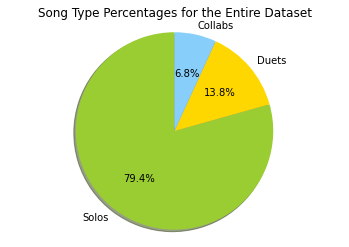

In [79]:
#Create pie chart visuals showing the comparitive size of values in the full dataset vs. the top 5% of the dataset

# Entire dataset
labels = 'Solos', 'Duets', 'Collabs'
sizes = [allsoloper, allduetper, allcollabper]
colors = ['yellowgreen', 'gold', 'lightskyblue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Song Type Percentages for the Entire Dataset")
plt.savefig('song_type_percentages_for_entire_dataset')
# plt.show()

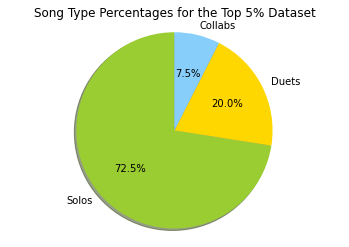

In [80]:
# Top 5% dataset
labels = 'Solos', 'Duets', 'Collabs'
sizes = [topsoloper, topduetper, topcollabper]
colors = ['yellowgreen', 'gold', 'lightskyblue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Song Type Percentages for the Top 5% Dataset")
plt.savefig('song_type_percentages_for_top_5%_dataset')
# plt.show()

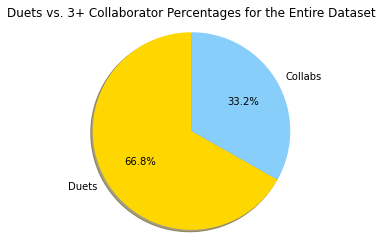

In [81]:
# just non solos, entire dataset
labels = 'Duets', 'Collabs'
sizes = [allduetper, allcollabper]
colors = ['gold', 'lightskyblue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels,colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Duets vs. 3+ Collaborator Percentages for the Entire Dataset")
plt.savefig('duet_vs_collab_entire_dataset')

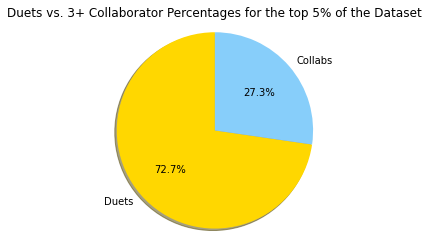

In [82]:
# just non-solos, top 5%
labels = 'Duets', 'Collabs'
sizes = [topduetper, topcollabper]
colors = ['gold', 'lightskyblue']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels,colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Duets vs. 3+ Collaborator Percentages for the top 5% of the Dataset")
plt.savefig('duet_vs_collab_top_5%_dataset')

In [55]:
# #create a dataframe of the mean values for all audio qualities in the most popular 5% dataset
# mostpop_info_df = pd.DataFrame(mostpop_df.mean())
# data_info_df = pd.DataFrame(data_df.mean())
# solo_info_df = pd.DataFrame(practicesolo_df.mean())
# duet_info_df = pd.DataFrame(practiceduet_df.mean())
# collab_info_df = pd.DataFrame(practicecollab_df.mean())
# mostpopsolo_info_df = pd.DataFrame(mostpopsolo_df.mean())
# mostpopduet_info_df = pd.DataFrame(mostpopduet_df.mean())
# mostpopcollab_info_df = pd.DataFrame(mostpopcollab_df.mean())

In [56]:
# #for ease of viewing, combine all previous dataframes into a single dataframe
# data_info_df.rename(columns={0:"Mean Value for All Songs"}).reset_index()
# Mean_Values = data_info_df.join(mostpop_info_df, lsuffix="Mean Value for All Songs").rename(columns={"0Mean Value for All Songs":"Mean Value for All Songs", "0":"Mean Value for Top 5% of Songs"})
# Mean_Values = Mean_Values.join(solo_info_df).rename(columns={0:"Mean Value for All Solos"})
# Mean_Values = Mean_Values.join(mostpopsolo_info_df).rename(columns={0:"Mean Value for Top 5% of Solos"})
# Mean_Values = Mean_Values.join(duet_info_df).rename(columns={0:"Mean Value for All Duets"})
# Mean_Values = Mean_Values.join(mostpopduet_info_df).rename(columns={0:"Mean Value for Top 5% of Duets"})
# Mean_Values = Mean_Values.join(collab_info_df).rename(columns={0:"Mean Value for All Collabs"})
# Mean_Values = Mean_Values.join(mostpopcollab_info_df).rename(columns={0:"Mean Value for Top 5% of Collabs"})
# Mean_Values



In [57]:
# #set up variables for upcoming visualizations based on the above chart
# Mean_Values_Valence = Mean_Values.iloc[[0],:]
# Mean_Values_Acousticness = Mean_Values.iloc[[2],:]
# Mean_Values_Danceability = Mean_Values.iloc[[3],:]
# Mean_Values_Duration = Mean_Values.iloc[[4],:]
# Mean_Values_Energy = Mean_Values.iloc[[5],:]
# Mean_Values_Instrumentalness = Mean_Values.iloc[[7],:]
# Mean_Values_Liveness = Mean_Values.iloc[[9],:]
# Mean_Values_Loudness = Mean_Values.iloc[[10],:]
# Mean_Values_Speechiness = Mean_Values.iloc[[13],:]
# Mean_Values_Tempo = Mean_Values.iloc[[14],:]

# #create function for building visualizations
# def groupbar():
#     plt.xticks(rotation=90)
#     plt.tight_layout()
#     plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#            ncol=2, mode="expand", borderaxespad=0.)
#     plt.show()

In [58]:
# #create function for running statistical analysis to go with each visualization below and to prepare to create a dataframe 
#     #of statistical information later
# col1 = []
# col2 = []
# def statanalysis():
#     "-----"
#     question = (f'T-Test for mean {x} of all songs vs. mean {x} of top 5% of all songs:')
#     print(question)
#     result = (stats.ttest_ind(practice2_df[x], mostpop_df[x], equal_var=False))
#     print(result)
#     col1.append(question)
#     col2.append(result)
#     "-----"
#     question = (f'T-Test for mean {x} of all solo songs vs. mean {x} of top 5% of all solo songs:')
#     print(question)
#     result = (stats.ttest_ind(practicesolo_df[x], mostpopsolo_df[x], equal_var=False))
#     print(result)
#     col1.append(question)
#     col2.append(result)
#     "-----"
#     question = (f'T-Test for mean {x} of all duets vs. mean {x} of top 5% of all duets:')
#     print(question)
#     result = (stats.ttest_ind(practiceduet_df[x], mostpopduet_df[x], equal_var=False))
#     print(result)
#     col1.append(question)
#     col2.append(result)
#     "-----"
#     question = (f'T-Test for mean {x} of all collabs vs. mean {x} of top 5% of all collabs:')
#     print(question)
#     result = (stats.ttest_ind(practicecollab_df[x], mostpopcollab_df[x], equal_var=False))
#     print(result)
#     col1.append(question)
#     col2.append(result)
#     "-----"

In [59]:
# #plot and analyze valence
# Mean_Values_Valence_plot = Mean_Values_Valence.plot.bar(rot=0)
# groupbar()
# Mean_Values_Valence.T.sort_values("valence")
# x = "valence"
# statanalysis()

In [60]:
# #plot and analyze acousticness
# Mean_Values_Acousticness_plot = Mean_Values_Acousticness.plot.bar(rot=0)
# groupbar()
# Mean_Values_Acousticness.T.sort_values("acousticness")
# x = "acousticness"
# statanalysis()

In [61]:
# #plot and analyze danceability
# Mean_Values_Danceability_plot = Mean_Values_Danceability.plot.bar(rot=0)
# groupbar()
# Mean_Values_Danceability.T.sort_values("danceability")
# x = "danceability"
# statanalysis()

In [62]:
# #plot and analyze duration
# Mean_Values_Duration_plot = Mean_Values_Duration.plot.bar(rot=0)
# groupbar()
# Mean_Values_Duration.T.sort_values("duration_ms")
# x = "duration_ms"
# statanalysis()

In [63]:
# #plot and analyze energy
# Mean_Values_Energy_plot = Mean_Values_Energy.plot.bar(rot=0)
# groupbar()
# Mean_Values_Energy.T.sort_values("energy")
# x = "energy"
# statanalysis()

In [64]:
# #plot and analyze instrumentalness
# Mean_Values_Instrumentalness_plot = Mean_Values_Instrumentalness.plot.bar(rot=0)
# groupbar()
# Mean_Values_Instrumentalness.T.sort_values("instrumentalness")
# x = "instrumentalness"
# statanalysis()

In [65]:
# #plot and analyze liveness
# Mean_Values_Liveness_plot = Mean_Values_Liveness.plot.bar(rot=0)
# groupbar()
# Mean_Values_Liveness.T.sort_values("liveness")
# x = "liveness"
# statanalysis()

In [66]:
# #plot and analyze loudness
# Mean_Values_Loudness_plot = Mean_Values_Loudness.plot.bar(rot=0)
# groupbar()
# Mean_Values_Loudness.T.sort_values("loudness")
# x = "loudness"
# statanalysis()

In [67]:
# #plot and analyze speechiness
# Mean_Values_Speechiness_plot = Mean_Values_Speechiness.plot.bar(rot=0)
# groupbar()
# Mean_Values_Speechiness.T.sort_values("speechiness")
# x = "speechiness"
# statanalysis()

In [68]:
# #plot and analyze tempo
# Mean_Values_Tempo_plot = Mean_Values_Tempo.plot.bar(rot=0)
# groupbar()
# Mean_Values_Tempo.T.sort_values("tempo")
# x = "tempo"
# statanalysis()

In [69]:
# #create dataframe of statistical analyses from above
# pd.set_option('display.max_colwidth', None)
# stats_df = pd.DataFrame(col1).rename(columns = {0:"Test"})

# stats_df["Statistic"] = col2
# stats_df.to_csv(r'Resources\stats.csv')
# csv_path = "Resources/stats.csv"
# stats2_df = pd.read_csv(csv_path)
# stats2_df[['Statistic','PValue']] = stats2_df.Statistic.str.split(",",expand=True) 
# stats2_df['Test'] = stats2_df['Test'].str.split('for',1).str[1]
# stats2_df['Statistic'] = stats2_df['Statistic'].str.split('=').str[1]
# stats2_df['PValue'] = stats2_df['PValue'].str.split('=').str[1]
# stats2_df['PValue'] = stats2_df['PValue'].str.split(')').str[0]
# stats2_df = stats2_df.drop(['Unnamed: 0'], axis=1)
# stats2_df['Statistic'] = pd.to_numeric(stats2_df['Statistic'], errors='coerce')
# stats2_df['PValue'] = pd.to_numeric(stats2_df['PValue'], errors='coerce')
# stats2_df = stats2_df.round(7)
# insignificant_df = stats2_df[stats2_df['PValue'] > .05]
# significant_df = stats2_df[stats2_df['PValue'] < .05]

In [70]:
# #create dataframe of tests which resulted in statistically insignificant data
# print("For each test, the null hypothesis is that the quality being compared between the relevant 'all songs'")
# print("and 'top 5% of songs' values within a category is irrelevant to the song's popularity.")
# print("-----")
# print('We must accept the null hypotheses for the following tests:')
# insignificant_df

In [71]:
# #create dataframe of statistically significant data
# pd.set_option('display.max_colwidth', None)
# print('We must reject the null hypotheses for the following tests:')
# significant_df

In [72]:
# #create dataframe of statistically significant data looking at characteristics of all songs in the dataset vs the top 5%
# significant_allsongs_df = significant_df[~significant_df.Test.str.contains("all songs") == False]
# significant_allsongs_df

In [73]:
# #create dataframe of statistically significant data looking at characteristics of solo songs in the dataset vs the top 5%
# significant_solo_df = significant_df[~significant_df.Test.str.contains("solo") == False]
# significant_solo_df

In [74]:
# #create dataframe of statistically significant data looking at characteristics of duets in the dataset vs the top 5%
# significant_duet_df = significant_df[~significant_df.Test.str.contains("duets") == False]
# significant_duet_df

In [75]:
# #create dataframe of statistically significant data looking at characteristics of collabs in the dataset vs the top 5%
# significant_collab_df = significant_df[~significant_df.Test.str.contains("collab") == False]
# significant_collab_df